# Introduction
The Idea behind SVM is to find the hyperplane that maximally separates the data in a classification problem. Most Decision based models like Decision Trees, Naive Bayes and even Neural Nets only aim at creating decision boundries that separate the classes in training datasets, While SVM aim at the decision boundry which is most likely to generalize well on test sets (i.e boundry that maximally separates the classes). 

This blog is aiming to perform different experiments on some simple dataset to better understand the internals of SVMs and its Tunable parameters. 

Let us begin with standard imports

In [36]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.svm import SVC
from sklearn.svm import SVR
import seaborn as sns; sns.set()
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets.samples_generator import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_squared_error

# Is SVM Generative or Discriminative?
A simple question for most people but provides opportunity to explain the two categories in brief. 
A generative classifier aims to model the process that would have resulted in the provided training dataset.
Naive Bayes are generative as we compute probabilities for the occurence of different features given classification output. Gaussian mixture modelling is another generative model in my opinion as we model the data distribution by a combinations of multiple gaussians the feature space. 
Alternately, SVM, Decision Trees, Neural Nets, Logistic Regression are all discriminative as they aim at finding some decisions (or decision boundries in feature space) that separate the classes. 

Let us create a simple linearly separable dataset.

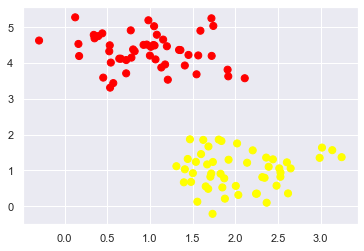

In [37]:
X, y = make_blobs(n_samples = 100, n_features = 2, centers = 2, random_state = 0, cluster_std = 0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

As seen we have created a sample dataset using make_blobs function with 100 data points (50 Red, 50 Yellow). Below we define some helper functions to plot & describe the decision boundaries, margin & support vectors of a SVM Model. 

In [38]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=60, c='k');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
def desc_svm_model(model):
    print('No. Support Vectors:' + str(model.n_support_))
    print('Support Vector Indices:' + str(model.support_))
    print('Support Vectors:' + str(model.support_vectors_))
    print('Kernel Used:' + str(model.kernel))
    if model.kernel == 'linear':
        print('Primal Coefficients(W):' + str(model.coef_))
    print('Primal Intercept(b):' + str(model.intercept_))
    print('Dual Coefficients(alpha):' + str(model.dual_coef_))
    print('SVM Fit Status:' + str(model.fit_status_))
    print('Classes:' + str(model.classes_))
    print('Class Weight:' + str(model.class_weight_))
    print('Train Data Shape:' + str(model.shape_fit_))
    print('Prob_A:' + str(model.probA_))
    print('Prob_B:' + str(model.probB_))

Let us build the first SVM model & see its performance for the created dataset. 

No. Support Vectors:[2 1]
Support Vector Indices:[ 3 54 44]
Support Vectors:[[0.5323772  3.31338909]
 [2.11114739 3.57660449]
 [1.46870582 1.86947425]]
Kernel Used:linear
Primal Coefficients(W):[[ 0.20882143 -1.2497097 ]]
Primal Intercept(b):[3.02935662]
Dual Coefficients(alpha):[[-0.45895512 -0.34386222  0.80281734]]
SVM Fit Status:0
Classes:[0 1]
Class Weight:[1. 1.]
Train Data Shape:(100, 2)
Prob_A:[]
Prob_B:[]


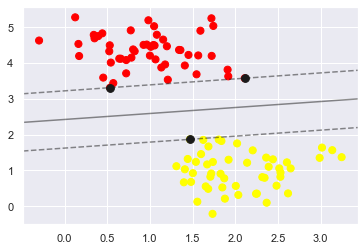

In [39]:
#Fit a simple SVM Model
svm1 = SVC(kernel='linear', gamma='auto')
svm1.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
desc_svm_model(svm1)
plot_svc_decision_function(svm1);

# Soft Margin - Optimizing Cost Function
The objective function of Hard Margin SVM is min 1/2||W||
We introduce the concept of soft margin, in cases where the data is not very well separated. The idea is to introduce a tradeoff between the width of margin & amount of misclassification error we are able to bear. 
Let us create a suitable dataset and run the standard SVM Model. 

No. Support Vectors:[6 6]
Support Vector Indices:[ 3  5 38 54 56 74  7 22 37 44 65 80]
Support Vectors:[[0.08848433 2.32299086]
 [1.44193252 2.76754364]
 [2.11567076 3.06896151]
 [3.2460247  2.84942165]
 [2.85942078 2.95602827]
 [0.1631238  2.57750473]
 [3.97820955 2.37817845]
 [1.31570453 2.44067826]
 [1.98702592 2.61100638]
 [0.88214412 2.84128485]
 [1.55723507 2.82719571]
 [1.19404184 2.80772861]]
Kernel Used:linear
Primal Coefficients(W):[[ 0.36361529 -5.22994091]]
Primal Intercept(b):[13.89567811]
Dual Coefficients(alpha):[[-1000000.         -1000000.           -52785.77399786 -1000000.
  -1000000.         -1000000.           339928.69577079   712857.07822693
   1000000.          1000000.          1000000.          1000000.        ]]
SVM Fit Status:0
Classes:[0 1]
Class Weight:[1. 1.]
Train Data Shape:(100, 2)
Prob_A:[]
Prob_B:[]


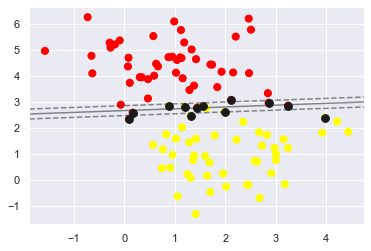

In [40]:
X, y = make_blobs(n_samples = 100, n_features = 2, centers = 2, random_state = 0, cluster_std = 1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
svm2 = SVC(kernel='linear', gamma='auto', C=1E6)
svm2.fit(X, y)
desc_svm_model(svm2)
plot_svc_decision_function(svm2);

 So now we have 12 support Vectors (6 for each class), with many of them being mis-classified. Although the model is still a linear 2-D plane with 2 coefficients and a intercept, it has become considerably complex in its dual version. In the dual optimization problem, we have 1 alpha value for each training example. The alpha value is 0 for all examples except the Support Vectors. Therefore we see the 12 non zero dual coefficiants for the 12 support vectors. 

# Multi Class Classification
SVC offers 2 modes: One vs Rest(ovr) & One Vs One (ovo) for the parameter decision_function_shape. For a 4 Class classification, ovr results in 4 models while ovo results in 6 (4 * (4-1) / 2) models. ovr is the default, and results in fewer models. Let us create a suitable dataset and check the SVC's behavior. 

0 - Red, 1 - Green, 2 - Blue, 3 - Yellow
OVR Configuration Costs for 4 Class Classification Data:
Cost: [[ 3.27935717  1.76546612 -0.22757846  0.86871325]]
Prediction: [0]
OVO Configuration Costs for 4 Class Classification Data:
Cost: [[ 3.51180784  0.83926673  0.82449077  0.76870699  0.36926307 -0.54396927]]
Prediction: [0]


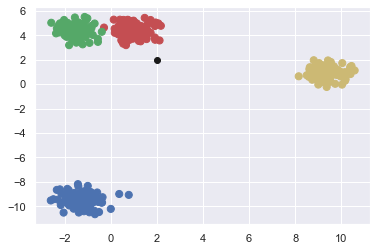

In [41]:
# 4 Classes - Make 4 separate datasets
d1, o1 = make_blobs(n_samples = 100, n_features = 2, centers = 1, random_state=0, cluster_std = 0.5)
d2, o2 = make_blobs(n_samples = 100, n_features = 2, centers = 1, random_state=1, cluster_std = 0.5)
d3, o3 = make_blobs(n_samples = 100, n_features = 2, centers = 1, random_state=2, cluster_std = 0.5)
d4, o4 = make_blobs(n_samples = 100, n_features = 2, centers = 1, random_state=4, cluster_std = 0.5)
X = np.vstack((d1,d2,d3,d4))
y = np.hstack((np.repeat(0,100), np.repeat(1,100), np.repeat(2,100), np.repeat(3,100))).T
print('0 - Red, 1 - Green, 2 - Blue, 3 - Yellow')
cols = np.hstack((np.repeat('r',100), np.repeat('g',100), np.repeat('b',100), np.repeat('y',100))).T
svm_ovr = SVC(kernel='linear', gamma='auto', decision_function_shape='ovr')
svm_ovr.fit(X, y)

svm_ovo = SVC(kernel='linear', gamma='auto', decision_function_shape='ovo')
svm_ovo.fit(X, y)

print('OVR Configuration Costs for 4 Class Classification Data:')
print('Cost: ' + str(svm_ovr.decision_function([[2,2]])))
print('Prediction: ' + str(svm_ovr.predict([[2,2]])))
print('OVO Configuration Costs for 4 Class Classification Data:')
print('Cost: ' + str(svm_ovo.decision_function([[2,2]])))
print('Prediction: ' + str(svm_ovo.predict([[2,2]])))
plt.scatter(X[:, 0], X[:, 1], c=cols, s=50, cmap='autumn', label=y)
plt.scatter(2, 2, c='k') #Test Point

OVR: 4 models for 4 classes was built. The cost function value is compared for the models and output from model_0 is observed to be highest. This suggests that this model maximally far from decision boundry for the test point (2,2). 
OVO: 6 models are built for 4 classes as follows: 0 vs 1, 0 vs 2, 0 vs 3, 1 vs 2, 1 vs 3 & 2 vs 3. Highest value here is seen for 0 vs 1 model, predicting the output as 0. 

# Unbalanced Problems
It is often the case when the classes to predict have very different importance and in general the more important class has lesser number of training samples. Common examples are Cancer / No Cancer, Terrorist / Not Terrorist, Airplane Prone to Crash / Healthy etc, where the former is more important and more rare. In such cases the model is required to have a higher recall (rather than higher accuracy), so that important events are not missed. 
Let us Create a suitable dummy dataset and check how SVC can handle it using Class Weights: 

Precision: 1.0 Recall: 0.85 F-Score: 0.9189189189189189 Support: None


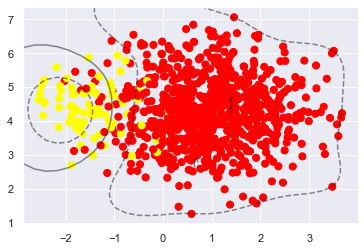

In [42]:
# 4 Classes - Make 4 separate datasets
d1, o1 = make_blobs(n_samples = 1000, n_features = 2, centers = 1, random_state=0, cluster_std = 1)
d2, o2 = make_blobs(n_samples = 100, n_features = 2, centers = 1, random_state=1, cluster_std = 0.7)
X = np.vstack((d1,d2))
y = np.hstack((np.repeat(0,1000), np.repeat(1,100))).T
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size=0.2, random_state=1)
svm4 = SVC(kernel='rbf', gamma='auto')
svm4.fit(X_Train, y_Train)
y_Pred = svm4.predict(X_Test)
precision, recall, fscore, support = precision_recall_fscore_support(y_Test, y_Pred, average='binary')
print('Precision: ' + str(precision) + ' Recall: ' + str(recall) +
      ' F-Score: ' + str(fscore) + ' Support: ' + str(support))
plt.scatter(X_Train[:, 0], X_Train[:, 1], c=y_Train, s=50, cmap='autumn')
plot_svc_decision_function(svm4, plot_support=False);

Precision: 0.5555555555555556 Recall: 1.0 F-Score: 0.7142857142857143 Support: None


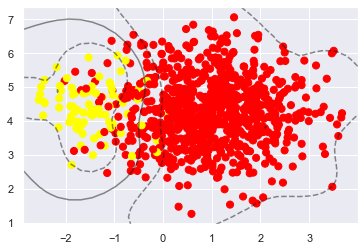

In [43]:
wsvm4 = SVC(kernel='rbf', gamma='auto', class_weight={1: 10})
wsvm4.fit(X, y)
y_Pred = wsvm4.predict(X_Test)
precision, recall, fscore, support = precision_recall_fscore_support(y_Test, y_Pred, average='binary')
print('Precision: ' + str(precision) + ' Recall: ' + str(recall) +
      ' F-Score: ' + str(fscore) + ' Support: ' + str(support))
plt.scatter(X_Train[:, 0], X_Train[:, 1], c=y_Train, s=50, cmap='autumn')
plot_svc_decision_function(wsvm4, plot_support=False);

The decision boundries of svm4 & wsvm4 clearly show that wsvm4 is giving more importance to class_1. The Recall value also increased from 0.85 to 1. The Trade-off between accuracy & recall can be done based on the problem at hand. 

# Regression
The Idea in SVR is to identify a linear decision boundary for which are training points have < epsilon error. In this case the The regression algorithm is also know as epsilon insensitive SVM.
Let us see it working for a suitable dataset. 

In [44]:
# Regression dataset - Polynomial relation with some noise
X, y = make_regression(n_samples = 1000, n_features = 2, n_informative=2, random_state=0)
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size=0.2, random_state=1)
svr1 = SVR(gamma = 'auto')
svr1.fit(X_Train, y_Train)
print(svr1.get_params())
y_Pred = svr1.predict(X_Test)
print('RMSE: ' + str(np.sqrt(mean_squared_error(y_Test, y_Pred))))

{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
RMSE: 25.42614196656479


# Kernel Trick - High Dimensional Projection
The Last interesting idea we discuss about SVM is the Kernel Trick. The idea is useful incase the data is "Non Linearly Separable". The trick is to project the input dimensions into a higher dimensional space. The data which was not linearly separable in original dimensions is more likely to become linearly separable in the projected space. The solution in the projected space is non linear when converted back to original input space. 
Let us see different Kernels at work. 

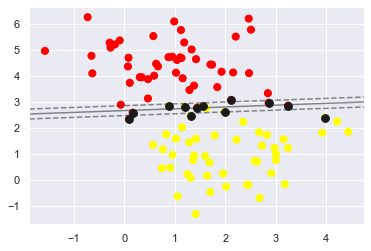

In [45]:
#Linear Kernel SVM
X, y = make_blobs(n_samples = 100, n_features = 2, centers = 2, random_state = 0, cluster_std = 1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
svm_lin = SVC(kernel='linear', gamma='auto', C=1E6)
svm_lin.fit(X, y)
plot_svc_decision_function(svm_lin);

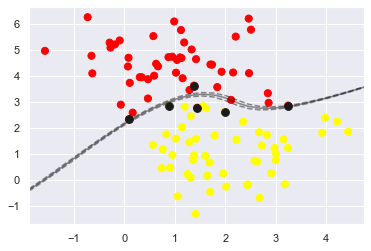

In [46]:
#Polynomial Kernel SVM
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
svm_poly = SVC(kernel='poly', gamma='auto', C=1E6)
svm_poly.fit(X, y)
plot_svc_decision_function(svm_poly);

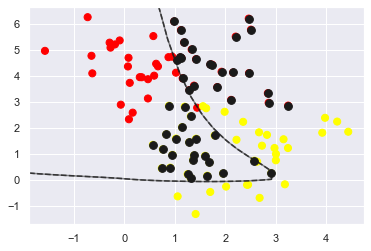

In [47]:
#Sigmoid Kernel SVM
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
svm_sig = SVC(kernel='sigmoid', gamma='auto', C=1E6)
svm_sig.fit(X, y)
plot_svc_decision_function(svm_sig);

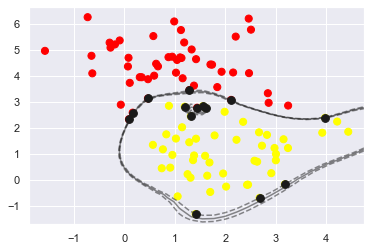

In [48]:
# Radial Basis Function Kernel SVM
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
svm_rbf = SVC(kernel='rbf', gamma='auto', C=1E6)
svm_rbf.fit(X, y)
plot_svc_decision_function(svm_rbf);

# References
1. https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
2. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
3. https://www.cs.utah.edu/~piyush/teaching/svm-solvers.pdf
4. Pyplot Functions: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.html#module-matplotlib.pyplot
5. LibSVM Documentation: https://www.csie.ntu.edu.tw/~cjlin/papers/libsvm.pdf
6. A tutorial on SVR: http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.114.4288